Acurácia do Modelo de Classificação: 33.33 %

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.40      0.67      0.50         3

    accuracy                           0.33         6
   macro avg       0.20      0.33      0.25         6
weighted avg       0.20      0.33      0.25         6


Exemplo de agrupamento de usuários:
   Idade  Canal_facil  Dificuldade_principal  Grupo
0      3            0                      2      2
1      3            0                      2      2
2      3            2                      2      1
3      3            3                      1      1
4      3            0                      1      2


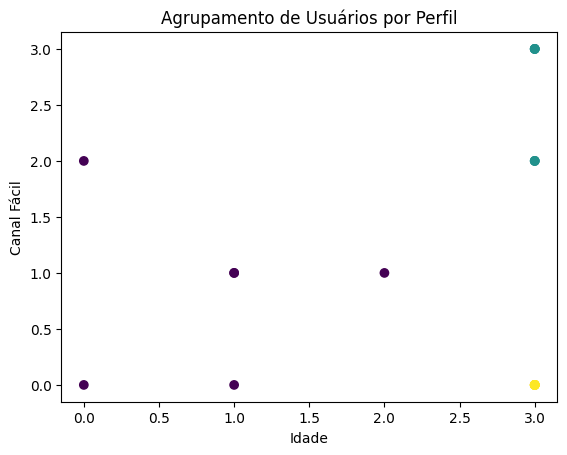

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import joblib
from flask import Flask, request, jsonify



df = pd.read_csv('data.csv')


df = df.drop(columns=['Carimbo de data/hora'])

df.columns = [
    'Problema_agendamento',
    'Idade',
    'Canal_facil',
    'Falta_suporte',
    'Preferiu_ir_pessoalmente',
    'Dificuldade_principal',
    'Preferencia_atendimento',
    'Sugestoes'
]


label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Separar features (X) e alvo (y)
X = df.drop('Problema_agendamento', axis=1)
y = df['Problema_agendamento']

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



modelo_class = RandomForestClassifier(random_state=42)
modelo_class.fit(X_train, y_train)

y_pred = modelo_class.predict(X_test)
print("Acurácia do Modelo de Classificação:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


kmeans = KMeans(n_clusters=3, random_state=42)
df['Grupo'] = kmeans.fit_predict(X)

print("\nExemplo de agrupamento de usuários:")
print(df[['Idade', 'Canal_facil', 'Dificuldade_principal', 'Grupo']].head())

plt.scatter(df['Idade'], df['Canal_facil'], c=df['Grupo'], cmap='viridis')
plt.xlabel('Idade')
plt.ylabel('Canal Fácil')
plt.title('Agrupamento de Usuários por Perfil')
plt.show()

joblib.dump(modelo_class, 'modelo_agendamento.joblib')
joblib.dump(label_encoders, 'encoders.joblib')


app = Flask(__name__)

# Carregar modelo e encoders
modelo = joblib.load('modelo_agendamento.joblib')
encoders = joblib.load('encoders.joblib')

@app.route('/predict', methods=['POST'])
def predict():
    dados = request.get_json()
    df_input = pd.DataFrame([dados])


    for col in df_input.columns:
        if col in encoders:
            df_input[col] = encoders[col].transform(df_input[col].astype(str))

    pred = modelo.predict(df_input)
    return jsonify({'previsao': int(pred[0])})

if __name__ == '__main__':
    app.run(debug=True)
